Install & Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Reproducibility

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

Dataset Generation

In [3]:
def generate_single_sample(image_size: int = 50):
    """
    Generate a single 50x50 grayscale image with one pixel = 255.

    Returns:
        image: (50, 50, 1) normalized image
        label: (x, y) normalized coordinates
    """
    image = np.zeros((image_size, image_size), dtype=np.float32)

    x = np.random.randint(0, image_size)
    y = np.random.randint(0, image_size)

    image[y, x] = 255.0
    image /= 255.0
    image = image[..., np.newaxis]

    label = np.array(
        [x / (image_size - 1), y / (image_size - 1)],
        dtype=np.float32
    )

    return image, label

In [4]:
def generate_dataset(num_samples: int, image_size: int = 50):
    images = []
    labels = []

    for _ in range(num_samples):
        img, lbl = generate_single_sample(image_size)
        images.append(img)
        labels.append(lbl)

    return np.array(images), np.array(labels)

Create Train / Val / Test Data

In [5]:
X, y = generate_dataset(num_samples=12000)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.4, random_state=42
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (9000, 50, 50, 1)
Val: (1800, 50, 50, 1)
Test: (1200, 50, 50, 1)


Visualize Sample Data

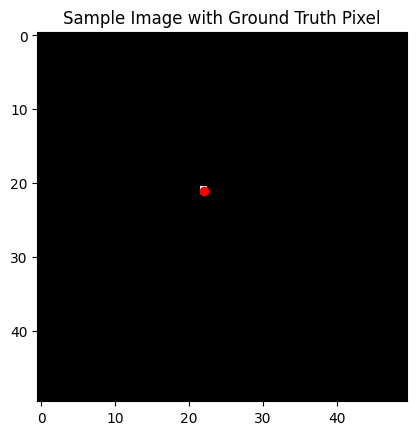

In [6]:
sample_img = X_train[0].squeeze()
sample_label = y_train[0] * 49

plt.imshow(sample_img, cmap="gray")
plt.scatter(sample_label[0], sample_label[1], c="red")
plt.title("Sample Image with Ground Truth Pixel")
plt.show()

Model Architecture

In [15]:
def build_model():
    model = models.Sequential([
        layers.Input(shape=(50, 50, 1)),

        layers.Conv2D(16, (3, 3), activation="relu", padding="same"),
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),

        # Preserve spatial information
        layers.Flatten(),

        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(2)  # (x, y)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )

    return model

In [16]:
model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    20,480,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,511,810 (78.25 MB)

 Trainable params: 20,511,810 (78.25 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - loss: 0.0778 - mae: 0.1702 - val_loss: 3.4216e-04 - val_mae: 0.0121
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - loss: 3.2123e-04 - mae: 0.0129 - val_loss: 9.5641e-05 - val_mae: 0.0065
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - loss: 7.3038e-05 - mae: 0.0060 - val_loss: 4.7395e-05 - val_mae: 0.0044
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - loss: 3.3295e-05 - mae: 0.0041 - val_loss: 3.5406e-05 - val_mae: 0.0038
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - loss: 2.3285e-05 - mae: 0.0034 - val_loss: 3.5016e-05 - val_mae: 0.0037
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - loss: 2.2161e-05 - mae: 0.0033 - val_loss: 3.4689e-05 - val_mae: 0.0041
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - loss: 4.0797e-05 - mae: 0.0046 - val_loss: 7.6559e-05 - val_mae: 0.0065
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - loss: 7.0854e-05 - mae: 0.0062 - val_loss: 1.0149e-04 - val_

Training & Validation Loss Graph

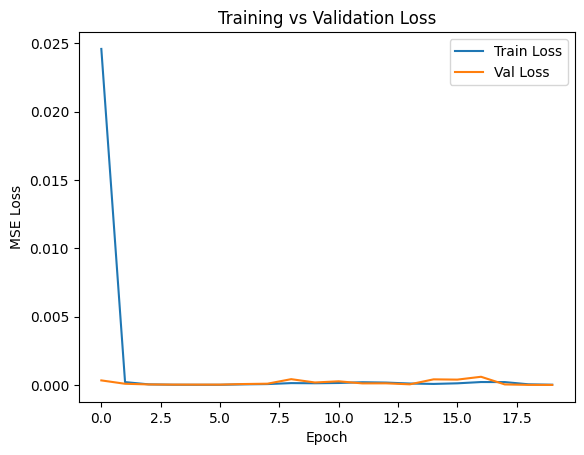

In [18]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

Model Evaluation on Test Data

In [19]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - loss: 2.4533e-05 - mae: 0.0027
Test MSE: 0.0000
Test MAE: 0.0027


Ground Truth vs Prediction Plot

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step


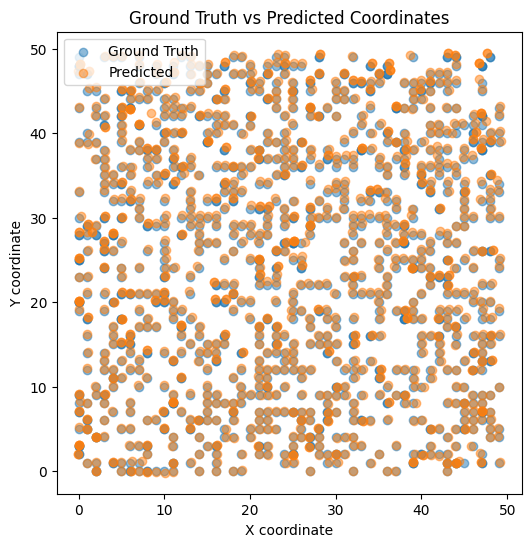

In [20]:
preds = model.predict(X_test)

# Convert back to pixel coordinates
y_true = y_test * 49
y_pred = preds * 49

plt.figure(figsize=(6, 6))
plt.scatter(y_true[:, 0], y_true[:, 1], alpha=0.5, label="Ground Truth")
plt.scatter(y_pred[:, 0], y_pred[:, 1], alpha=0.5, label="Predicted")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend()
plt.title("Ground Truth vs Predicted Coordinates")
plt.show()

Pixel Distance Error

In [21]:
preds = model.predict(X_test)

y_true = y_test * 49
y_pred = preds * 49

pixel_error = np.sqrt(
    (y_true[:, 0] - y_pred[:, 0]) ** 2 +
    (y_true[:, 1] - y_pred[:, 1]) ** 2
)

print("Mean Pixel Error:", np.mean(pixel_error))
print("Median Pixel Error:", np.median(pixel_error))

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step
Mean Pixel Error: 0.21141239
Median Pixel Error: 0.187623


**Explanation**

**Dataset Rationale:**
The dataset was synthetically generated because the problem is deterministic and requires precise control over pixel positions. Each image contains exactly one active pixel placed uniformly at random, ensuring balanced spatial coverage.

**Model Choice:**
A lightweight CNN was used to extract spatial features and regress pixel coordinates. The task is framed as regression using MSE loss.

**Normalization:**
Images and coordinates were normalized to improve numerical stability during training.